In [7]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# データの読み込み

In [9]:
Data_01=np.load("results2022/01x40_padded_3219.npy",allow_pickle=True)
Data_02Nami=np.load("results2022/02x40_padded.npy",allow_pickle=True)
print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

DataLabel_01 = np.zeros(len(Data_01), dtype=np.int32)
DataLabel_02Nami = np.ones(len(Data_02Nami), dtype=np.int32)
print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

Data = np.concatenate((Data_01, Data_02Nami), axis = 0)
Label = np.concatenate((DataLabel_01, DataLabel_02Nami), axis = 0)

Data_01.shape: (3219, 100, 100, 3)
Data_02Nami.shape: (3219, 100, 100, 3)
Data_01.shape: (3219, 100, 100, 3)
Data_02Nami.shape: (3219, 100, 100, 3)


# データ前処理

In [10]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), torch.tensor(self.y[idx], dtype=torch.long)


dataloader = cell_dataset(Data, Label)

In [11]:
batch_size = 128

test_size = int(len(dataloader)*0.1)
trainval_size = len(dataloader)-test_size
train_size = int(0.8*trainval_size)
val_size = trainval_size-train_size

trainval_data, test_data = torch.utils.data.random_split(dataloader, [trainval_size, test_size])
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [12]:
train_data_01 = 0
for i in range(train_size):
    train_data_01+=train_data[i][1].item()
print("Total number of train : ", train_size)
print("train_class_0: ", train_size-train_data_01)
print("train_class_1: ", train_data_01)

val_data_01 = 0
for i in range(val_size):
    val_data_01+=val_data[i][1].item()
print("\nTotal number of val : ", val_size)
print("val_class_0: ", val_size-val_data_01)
print("val_class_1: ", val_data_01)

test_data_01 = 0
for i in range(test_size):
    test_data_01+=test_data[i][1].item()
print("\nTotal number of val : ", test_size)
print("test_class_0: ", test_size-test_data_01)
print("test_class_1: ", test_data_01)

Total number of train :  4636
train_class_0:  2268
train_class_1:  2368

Total number of val :  1159
val_class_0:  604
val_class_1:  555

Total number of val :  643
test_class_0:  347
test_class_1:  296


# Model development

In [47]:
class Feactor(nn.Module):
    def __init__(self, image_size):
        super(Feactor,self).__init__()
        self.image_size = image_size
        
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.ReLU()
        )
        self.residual_layer = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
#             ResidualBlock(64),
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(64,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(1),
        )
        self.dense_layer=nn.Sequential(
#             nn.AdaptiveAvgPool2d((10)),
            nn.Flatten(),
            nn.Linear(1*100*100, 2),
        )

    
    nn.Linear(5*5*128, 1024),
    def forward(self, input_image):
        pre = self.pre_layer(input_image)
        res = self.residual_layer(pre)
        last = self.last_layer(res)
        output = self.dense_layer(last)
        return output
    
    
class ResidualBlock(nn.Module):
    def __init__(self, input_channel):
        super(ResidualBlock,self).__init__()
        self.residualblock = nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
        )
    def forward(self, x):
        residual = self.residualblock(x)
        return x + residual

In [48]:
image_size = 100
ngpu = 4
model = Feactor(image_size).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


In [49]:
# model = torch.load("Feactor.pkl")

# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

In [50]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_func = nn.NLLLoss()

weights = torch.tensor([(len(Data_01)+len(Data_02Nami))/len(Data_01), 
                        (len(Data_01)+len(Data_02Nami))/len(Data_02Nami)]).cuda()
loss_function = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

In [51]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [53]:
n_epoches = 50
for epoch in range(n_epoches):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.568, Accuracy: 0.741], Valid [Loss: 0.768, Accuracy: 0.517]
EPOCH: 1, Train [Loss: 0.564, Accuracy: 0.725], Valid [Loss: 0.518, Accuracy: 0.746]
EPOCH: 2, Train [Loss: 0.525, Accuracy: 0.748], Valid [Loss: 0.506, Accuracy: 0.728]
EPOCH: 3, Train [Loss: 0.567, Accuracy: 0.738], Valid [Loss: 0.667, Accuracy: 0.593]
EPOCH: 4, Train [Loss: 1.822, Accuracy: 0.635], Valid [Loss: 2.274, Accuracy: 0.521]
EPOCH: 5, Train [Loss: 1.310, Accuracy: 0.638], Valid [Loss: 1.122, Accuracy: 0.531]
EPOCH: 6, Train [Loss: 0.674, Accuracy: 0.684], Valid [Loss: 0.607, Accuracy: 0.772]
EPOCH: 7, Train [Loss: 0.542, Accuracy: 0.749], Valid [Loss: 0.595, Accuracy: 0.723]
EPOCH: 8, Train [Loss: 0.564, Accuracy: 0.728], Valid [Loss: 0.577, Accuracy: 0.727]
EPOCH: 9, Train [Loss: 0.516, Accuracy: 0.753], Valid [Loss: 0.516, Accuracy: 0.756]
EPOCH: 10, Train [Loss: 0.722, Accuracy: 0.642], Valid [Loss: 0.769, Accuracy: 0.763]
EPOCH: 11, Train [Loss: 0.548, Accuracy: 0.733], Valid [Loss: 0.

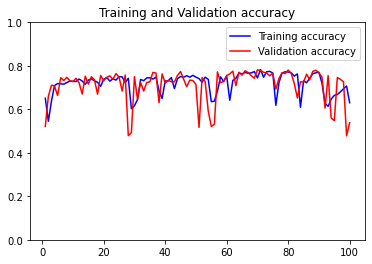

<Figure size 432x288 with 0 Axes>

In [54]:
# train processing plot
n_epoches = 100
epochs=range(1,n_epoches+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# test with testdata

In [55]:
# Test
total = 0
acc_test = 0
y_ture = []
y_pred = []
out_pred = []

model.eval()
for x, y in dataloader_test:
    total += y.size()[0]
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    pred = output.argmax(1)
    acc_test += (pred == y).float().sum().item()
#     for i in range(y.size()[0]):
#         y_pred.append(pred[i])
#         y_ture.append(y[i])
#         out_pred.append(output[i,1])



print('accuracy_score: {:.3f}'.format(acc_test/total))
# y_ture = np.array(y_ture)
# y_pred = np.array(y_pred)
# out_pred = np.array(out_pred)
# print("total_test: {:}" .format(total))
# print('accuracy_score: {:.3f}'.format(accuracy_score(y_ture, y_pred)))
# print('precision_score: {:.3f}'.format(precision_score(y_ture, y_pred)))
# print('roc_auc_score: {:.3f}'.format(roc_auc_score(y_ture, out_pred)))

# fpr, tpr, thresholds = roc_curve(y_true, out_pred,drop_intermediate=True)
# plt.plot(fpr, tpr, marker='.')
# plt.xlabel('FPR: False positive rate')
# plt.ylabel('TPR: True positive rate')
# plt.grid()

accuracy_score: 0.557


# Feature Detection

In [56]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

In [57]:
def predict(model, input_img, label):
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(input_img).unsqueeze(0).to(device)
    output = model(input_tensor)
    y = output.argmax(1).cpu().item()
    return y==label, y
        
def get_feature(model, input_img, target_layer):
    for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name))
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(input_img).unsqueeze(0).to(device)
    output = model(input_tensor)
    # plot each layer result
    for key in [target_layer]:
        bn = feature_activation[key].cpu()
    return bn[0,0,:,:]

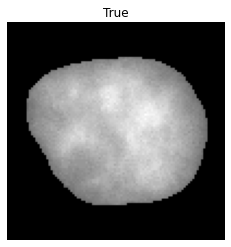

max: 7.469, min: 1.150
max: 255, min: 39


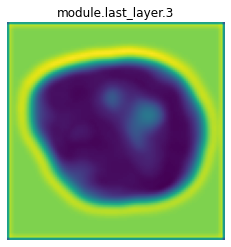

In [94]:
target_layers = ["module.last_layer.3"]
label = 1

if label == 1:
    img = Data_02Nami[1]
else:
    img = Data_01[1]

for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name))
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
output = model(input_tensor)
y = output.argmax(1).cpu().item()
plt.title(y==label)
plt.imshow(img/np.amax(img))
plt.axis("off")
plt.show()

i=1
for key in target_layers:
    bn = feature_activation[key].cpu()[0,0,:,:]
    print('max: {:.3f}, min: {:.3f}'.format(torch.amax(bn),torch.amin(bn)))
    bn = (bn*(255/torch.amax(bn))).to(torch.int64)
    print('max: {:}, min: {:}'.format(torch.amax(bn),torch.amin(bn)))
    plt.title(key)
    plt.axis("off")
    plt.imshow(bn)
    i+=1

In [86]:
bn[50,50]

tensor(1.5144)

In [78]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

module.pre_layer.0  :  torch.Size([1, 64, 100, 100])
module.pre_layer.1  :  torch.Size([1, 64, 100, 100])
module.pre_layer  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.0  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.1  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.2  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.3  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.4  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.5  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.6  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock.7  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0.residualblock  :  torch.Size([1, 64, 100, 100])
module.residual_layer.0  :  torch.Size([1, 64, 100, 100])
module.residual_layer.1.residualblock.0  :  torch.Size([1, 64, 100, 100])
module.residual_layer.1.residualblock.1  :  tor

# save model

In [96]:
# for param in model.parameters():
#     param.requires_grad = True
# torch.save(model,"Feactor.pkl")